In [5]:
%matplotlib inline
import sys
sys.path.append("..")

In [6]:
import random

import deeptrack as dt

import numpy as np
import skimage.color
import matplotlib.pyplot as plt
import tensorflow as tf

tracker_input_size = 64


In [7]:

commons = dt.DummyFeature(
    image_size=tracker_input_size,
    position=lambda image_size: image_size / 2 + np.random.randn(2) * 2
)

arguments = dt.Arguments(
    noise_level=10,
    particle_type="moon",
    ellipse_radius_ratio=2
)

fluorescence_microscope = dt.Fluorescence(
    NA=0.8,                
    resolution=1e-6,     
    magnification=10,
    wavelength=680e-9,
    output_region=(0, 0, tracker_input_size, tracker_input_size)
)

poisson_noise = dt.Poisson(
    snr=lambda: np.random.rand()*7 + 20,
    background=0.1,
    
)

u = dt.units
particle = dt.Ellipse(radius=lambda ratio: np.array((1, 1 * ratio)) * u.um, position=commons.position, ratio=arguments.ellipse_radius_ratio)



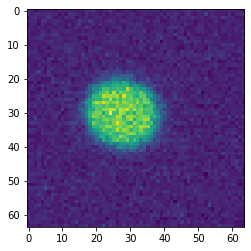

In [8]:


pipeline = (
    fluorescence_microscope(particle)
    >> dt.Affine(rotate=lambda:np.random.rand() * 2 * np.pi)
    >> dt.NormalizeMinMax() 
    + 0.2
) >> dt.Poisson(snr=arguments.noise_level, background=0.2) >> dt.NormalizeMinMax()

pipeline.bind_arguments(arguments)

pipeline.plot(resolve_kwargs={"ellipse_radius_ratio": 1.1})

In [11]:
moon_dataset = [pipeline.update().resolve( ellipse_radius_ratio=np.random.rand() + 1) for _ in range(500)]
moon_dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) for d in moon_dataset]


In [34]:


# model12 = dt.models.AutoTracker(
#     input_shape=(tracker_input_size, tracker_input_size, 1),
#     mode="orientation",
#     symmetries=2,
# )

# model15 = dt.models.AutoTracker(
#     input_shape=(tracker_input_size, tracker_input_size, 1),
#     mode="orientation",
#     symmetries=2,
# )


# model18 = dt.models.AutoTracker(
#     input_shape=(tracker_input_size, tracker_input_size, 1),
#     mode="orientation",
#     symmetries=2,
# )



model12.fit(dt.Value(pipeline.update().resolve( ellipse_radius_ratio=1.1)), batch_size=8, epochs=30)
# model15.fit(dt.Value(pipeline.update().resolve( ellipse_radius_ratio=1.5)), batch_size=8, epochs=30)
# model18.fit(dt.Value(pipeline.update().resolve( ellipse_radius_ratio=1.7)), batch_size=8, epochs=30)

Generating 800 / 400 samples before starting training
Epoch 1/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0902
Epoch 2/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0664
Epoch 3/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0601
Epoch 4/30
800/800 [==============================] - 8s 9ms/step - loss: 0.0515
Epoch 5/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0519
Epoch 6/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0466
Epoch 7/30
800/800 [==============================] - 7s 9ms/step - loss: 0.0462
Epoch 8/30
800/800 [==============================] - 8s 10ms/step - loss: 0.0450
Epoch 9/30
800/800 [==============================] - 8s 11ms/step - loss: 0.0432
Epoch 10/30
800/800 [==============================] - 8s 9ms/step - loss: 0.0465
Epoch 11/30
800/800 [==============================] - 8s 9ms/step - loss: 0.0428
Epoch 12/30
800/800 [=========================

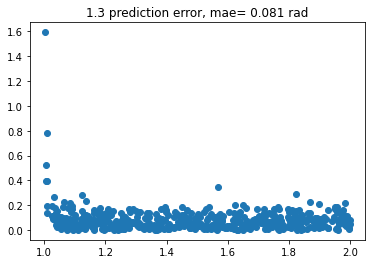

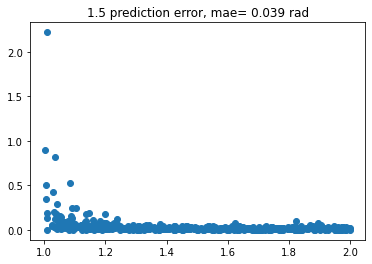

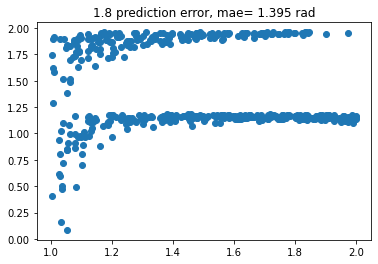

In [35]:

for (
    model,
    dataset,
    symmetries,
    name
) in zip(
    [model12, model15, model18],
    [moon_dataset, moon_dataset, moon_dataset],
    [2, 2, 2],
    [1.3, 1.5, 1.8]
):

    predicted_angle = model.predict(np.array(dataset))
    predicted_angle_2 = model.predict(np.array(dataset)[:, ::-1])

    angle = np.arctan2(predicted_angle[:, 1], predicted_angle[:, 0]) / symmetries
    angle_2 = np.arctan2(predicted_angle_2[:, 1], predicted_angle_2[:, 0]) / symmetries


    dataset_labels = [np.mean(d.get_property("rotate", get_one=False), axis=0) % ( 2 * np.pi / symmetries ) for d in dataset]
    x = [d.get_property("ratio", get_one=True) for d in dataset]

    diff = (angle - dataset_labels)

    diff = (diff - np.mean(diff) + np.pi / symmetries) % (np.pi)
    diff = diff - np.mean(diff)


    plt.scatter(x, np.abs(diff))
    # plt.ylim([0, 1])
    plt.title(f"{name} prediction error, mae={np.mean(np.abs(diff)): .3f} rad")
    plt.show()



In [ ]:
for _x, y in zip(x, dataset):
    
    ang = np.arctan2(_x[3], _x[2]) / 2
    _x = np.cos(ang)
    _y = np.sin(ang)
    
    plt.imshow(y)
    plt.quiver([32], [32], [_x], [_y], color="w", scale=4)
    plt.show()
    

NameError: name 'x' is not defined

In [ ]:
for _x, y in zip(x, dataset):
    
    ang = np.arctan2(_x[3], _x[2]) / 2
    _x = np.cos(ang)
    _y = np.sin(ang)
    
    plt.imshow(y)
    plt.quiver([32], [32], [_x], [_y], color="w")
    plt.show()
    